In [2]:
import sys
import pathlib
sys.path.insert(0, str(pathlib.Path(
).resolve().parent)) #.. this has to be the folder reCNN_visual_prosthesis
import wandb
import glob
from models import reCNN_bottleneck_CyclicGauss3d_no_scaling
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from Antolik_dataset import AntolikDataset, AntolikDataModule
from experiments.utils import pickle_read, download_model, get_neuron_estimates, reconstruct_orientation_maps, visualize_preferred_orientations, rotate_and_compute_distances, circular_distance
import pytorch_lightning as pl
import torch
from model_trainer import run_wandb_training
from energy_model.energy_model import EnergyModel, EnergyModelIndividual
from train_on_antolik import get_config
from model_trainer import Antolik_dataset_preparation_function, get_model

import torch.nn as nn
import torch.optim as optim
from experiments.utils import pickle_read, download_model
from tqdm import tqdm

# First, create the trainable image and train it on the first neuron of the encoder

In [3]:
import torch
import torch.nn as nn

def StandardizeClip(mean, std, pixel_min=None, pixel_max=None, dim=[1, 2, 3]):
    # module that uses Standardize and Clip, see below
    transf = [Normalize(mean=mean, std=std, dim=dim)]
    if pixel_min != None or pixel_max != None:
        transf.append(Clip(pixel_min=pixel_min, pixel_max=pixel_max))
    return nn.Sequential(*transf)

class Normalize(nn.Module):
    # module that normalizes the image to have mean and std
    def __init__(self, mean=None, std=None, dim=None, eps=1e-12):
        super().__init__()
        self.mean = mean
        self.std = std
        self.dim = dim
        self.eps = eps
    def forward(self, x, iteration=None):
        x_mean = x.mean(dim=self.dim, keepdims=True)
        target_mean = self.mean if self.mean is not None else x_mean
        x_std = x.std(dim=self.dim, keepdims=True)
        target_std = self.std if self.std is not None else x_std
        return target_std * (x - target_mean) / (x_std + self.eps) #+ target_mean

class Clip(nn.Module):
    # module that only clips values of the image
    def __init__(self, pixel_min, pixel_max):
        super().__init__()
        self.pixel_min = pixel_min
        self.pixel_max = pixel_max
    def forward(self, x):
        x = torch.clamp(x, min=self.pixel_min, max=self.pixel_max)
        return x

In [4]:
class TrainableImage(nn.Module):
    def __init__(self, img_size, n=1, c=1):
        super().__init__()
        self.img = nn.Parameter((torch.randn(n, c,*img_size)))
    def forward(self):
        return self.img

In [5]:
def plot_img(img, pixel_min, pixel_max):
    plt.figure(figsize = (8,8))
    if type(img) != np.ndarray:
        img = img.cpu().detach().squeeze().numpy()
    plt.imshow(img, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    plt.colorbar()
    plt.show()

In [6]:
bottleneck_model = download_model(artifact_name="reCNN_bottleneck_CyclicGauss3d:v1011", model_class=reCNN_bottleneck_CyclicGauss3d_no_scaling)
energy_model = download_model(artifact_name="EnergyModel:v486", model_class=EnergyModel)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: csng-cuni (use `wandb login --relogin` to force relogin)


wandb: wandb version 0.15.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Global seed set to 42
/opt/conda/lib/python3.8/site-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")
/opt/conda/lib/python3.8/site-packages/neuralpredictors/layers/cores/conv2d.py:128: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)


Model from ./artifacts/reCNN_bottleneck_CyclicGauss3d:v1011/epoch=13-step=55999.ckpt loaded!


/auto/budejovice1/mpicek/reCNN_visual_prosthesis/readout.py:344: UserWarning: sigma is sampled from uniform distribution, instead of a fixed value. Consider setting fixed_sigma to True
  warnings.warn(


wandb: wandb version 0.15.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Global seed set to 42
wandb: Downloading large artifact EnergyModel:v486, 115.66MB. 1 files... Done. 0:0:0
/opt/conda/lib/python3.8/site-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


(55, 55)
[-5.5, 5.5]
[-5.5, 5.5]
-------------
Model from ./artifacts/EnergyModel:v486/epoch=7-step=2127.ckpt loaded!


# Now train Gabor filter on the obtained MEI

In [7]:
config = get_config()
config["train_data_dir"] = "/storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik_reparametrized_small/one_trials.pickle"
config["test_data_dir"] = "/storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik_reparametrized_small/ten_trials.pickle"

dm = Antolik_dataset_preparation_function(config, load_data=True)

pos_x, pos_y, orientations = dm.get_ground_truth(
    ground_truth_positions_file_path=config["ground_truth_positions_file_path"], 
    ground_truth_orientations_file_path=config["ground_truth_orientations_file_path"], 
    in_degrees=False, 
    positions_minus_y=config["positions_minus_y"], 
    positions_minus_x=config["positions_minus_x"], 
    positions_swap_axes=config["positions_swap_axes"]
)

Data loaded successfully!
Loaded precomputed mean from /storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik_reparametrized_small/one_trials_mean.npy


In [8]:
class GaborFilter(nn.Module):
    def __init__(self, min_pixel_intensity=-1.7, max_pixel_intensity=2, min_sigma=0.0000000001, 
                 init_pos_x=None, init_pos_y=None, init_ori=None, init_f=None, dataset_default_ori_shift=90):
        super().__init__()

        # initialize to large enough to cover the whole visual field, allowing the gradient
        # to flow from all positions, so that the model can decide on the best positions of neuron
        self.sigma_x = nn.Parameter(torch.ones(1) * 0.94) 
        self.sigma_y = nn.Parameter(torch.ones(1) * 0.94)

        if init_f is not None:
            self.f = nn.Parameter(torch.ones(1) * init_f)
        else:
            self.f = nn.Parameter(torch.rand(1))

        if init_ori is not None:
            # remainder because the dataset has 90 degrees default shift
            self.ori = nn.Parameter(torch.ones(1) * init_ori)
        else:
            self.ori = nn.Parameter(torch.rand(1))

        if init_pos_x is not None:
            self.pos_x = nn.Parameter(torch.ones(1) * init_pos_x)
        else:
            self.pos_x = nn.Parameter(torch.rand(1))

        if init_pos_y is not None:
            self.pos_y = nn.Parameter(torch.ones(1) * init_pos_y)
        else:
            self.pos_y = nn.Parameter(torch.rand(1))

        self.shift = nn.Parameter(torch.rand(1))
        self.scale = nn.Parameter(torch.ones(1))

        self.min_pixel_intensity = min_pixel_intensity
        self.max_pixel_intensity = max_pixel_intensity

        self.min_sigma = min_sigma

        x = np.linspace(-5.5, 5.5, 55)
        y = np.linspace(-5.5, 5.5, 55)
        self.meshgrid_x, self.meshgrid_y = np.meshgrid(x, y)
        self.meshgrid_x =  torch.from_numpy(self.meshgrid_x).float()
        self.meshgrid_y =  torch.from_numpy(self.meshgrid_y).float()

        self.meshgrid_x = self.meshgrid_x.to('cuda')
        self.meshgrid_y = self.meshgrid_y.to('cuda')
        self.dataset_default_ori_shift = dataset_default_ori_shift

    def forward(self, x):
        ori = torch.remainder(self.ori + ((self.dataset_default_ori_shift / 180) * np.pi), np.pi)
        meshgrid_x_rotated = self.meshgrid_x * torch.cos(ori) - self.meshgrid_y * torch.sin(ori)
        meshgrid_y_rotated = self.meshgrid_x * torch.sin(ori) + self.meshgrid_y * torch.cos(ori)

        rotated_pos_x = torch.cos(ori) * self.pos_x - torch.sin(ori) * self.pos_y
        rotated_pos_y = torch.sin(ori) * self.pos_x + torch.cos(ori) * self.pos_y

        gaussian_filter = torch.clip(self.scale, min=self.min_pixel_intensity, max=self.max_pixel_intensity) * torch.exp(
            -0.5
            * (
                (
                    torch.square(meshgrid_x_rotated - rotated_pos_x)
                    / (torch.square(self.sigma_x) + self.min_sigma) # + minimum_sigma as we don't want to divide by 0
                )
                + (
                    torch.square(meshgrid_y_rotated - rotated_pos_y)
                    / (torch.square(self.sigma_y) + self.min_sigma) # + minimum_sigma as we don't want to divide by 0
                )
            )
        )

        cosine_filter = torch.cos(
            2
            * np.pi
            * (meshgrid_x_rotated + rotated_pos_x)
            * self.f
            + torch.remainder(self.shift, 2*np.pi)
        )

        gabor_filter = gaussian_filter * cosine_filter
        out = torch.tensordot(x, gabor_filter)
        img_err = torch.square(x - gabor_filter)
        return out, gabor_filter, img_err

In [9]:
def show_three_images(image1, image2, image3, pixel_min, pixel_max):
    # plt.figure(figsize = (8,16))
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image1, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    ax[1].imshow(image2, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    ax[2].imshow(image3, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    plt.show()

def show_four_images(image1, image2, image3, image4, pixel_min, pixel_max):
    # plt.figure(figsize = (8,16))
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    ax[0].imshow(image1, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    ax[1].imshow(image2, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    ax[2].imshow(image3, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    ax[3].imshow(image3, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    plt.show()

## Set the positions to 0 and slowly rotate the neuron
**This check ensures that the network is really rot equivarian. TODO: try different locations - to ensure location equivariancy.t**
**Delete this bottom cell for seeing real neurons (their real ori and pos)**

In [10]:
# pos_x[0] = 0
# pos_y[0] = 0
# orientations[0] = 0
# pos_x[1] = 0
# pos_y[1] = 0
# orientations[1] = 0.25
# pos_x[2] = 0
# pos_y[2] = 0
# orientations[2] = 0.5
# for i in range(30):
#     pos_x[i] = 0
#     pos_y[i] = 0
#     orientations[i] = 1/30 * i

#     bottleneck_model.readout.mu[0, 0, i, 0, 0] = 0
#     bottleneck_model.readout.mu[0, 0, i, 0, 1] = 0
#     bottleneck_model.readout.mu[0, 0, i, 0, 2] = 1/30 * i

# energy_model.positions_x = torch.zeros(encoder.positions_x.shape)
# energy_model.positions_y = torch.zeros(encoder.positions_y.shape)
# for i in range(30):
#     energy_model.positions_y[i] = 1/30 * i
# energy_model.init_gabor_filters((55, 55), [-5.5, 5.5], [-5.5, 5.5])


### We will always train the MEI and then fit Gabor filter on it
- here, we also want to see the parameters of the Gabor
- therefore, we do the same computation on different neurons

**The neurons have sometimes swapped sides (purple and green). The activation for inversed MEI (if we manually swap the purple and green) is almost the same, so it is alright. Our network obviously learned the complex behaviour of V1 cells.**

In [11]:
def train_mei(model, device, neuron, std=0.1, steps=500):
    
    bar = tqdm(range(steps))

    min_pixel_value = -1.757
    max_pixel_value = 2.04
    my_clip = StandardizeClip((max_pixel_value + min_pixel_value) / 2, std, min_pixel_value, max_pixel_value)

    im = TrainableImage([55, 55])

    optim = torch.optim.Adam(im.parameters(), lr=0.02)

    im.to(device=device)
    model.to(device=device)
    my_clip.to(device=device)
    im.train()
    model.eval()
    
    activation = None
    for step in bar:
        optim.zero_grad()
        activation = model(my_clip(im()))
        loss = -torch.mean(activation[:,neuron])
        loss.backward()
        optim.step()
        bar.set_description(f"activation = {-loss}")
    print("Last activation", torch.mean(activation[:,neuron]))

    # Testing the polarity (make an inverse MEI and see if the activation is still high)
    my_clip.eval()
    mean = my_clip(im()).mean()
    inversed_MEI = -(my_clip(im()) - mean) + mean
    inverse_activation = model(inversed_MEI)
    print("Inverse activation", torch.mean(inverse_activation[:,neuron]))
    return my_clip(im()).cpu().detach().squeeze().numpy()

def train_gabor(gabor, mei, device, steps=4000):
    gabor.to(device=device)

    optim = torch.optim.Adam(gabor.parameters(), lr=0.01)
    gabor.train()
    mei = torch.from_numpy(mei)
    mei = mei.to(device=device)

    gabor_bar = tqdm(range(steps))

    for step in gabor_bar:
        optim.zero_grad()
        err, gab, img_err = gabor(mei)
        loss = torch.mean(img_err)
        loss.backward()
        optim.step()
        gabor_bar.set_description(f"loss = {-loss}")

    _, gab, _ = gabor(mei)
    return gab.cpu().detach().squeeze().numpy()

activation = 11.543139457702637: 100%|██████████| 500/500 [01:22<00:00,  6.07it/s]


Last activation tensor(11.5431, device='cuda:0', grad_fn=<MeanBackward0>)
Inverse activation tensor(10.6893, device='cuda:0', grad_fn=<MeanBackward0>)


activation = 10.21536922454834: 100%|██████████| 500/500 [00:04<00:00, 103.63it/s] 


Last activation tensor(10.2154, device='cuda:0', grad_fn=<MeanBackward0>)
Inverse activation tensor(10.2157, device='cuda:0', grad_fn=<MeanBackward0>)


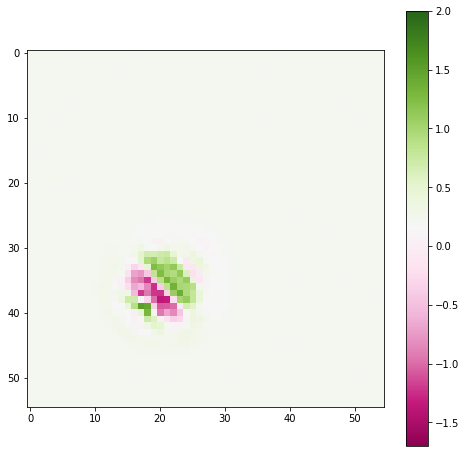

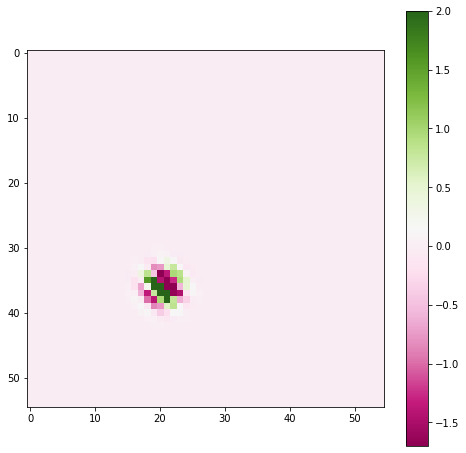

loss = -0.04808211326599121: 100%|██████████| 4000/4000 [00:14<00:00, 274.07it/s] 


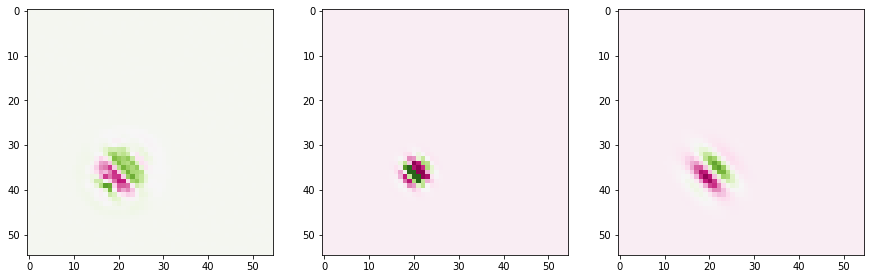

Sigmas_x [0.56400615]
Sigmas_y [0.67069715]
fs [0.61634254]


activation = 10.514724731445312: 100%|██████████| 500/500 [00:15<00:00, 31.38it/s]


Last activation tensor(10.5147, device='cuda:0', grad_fn=<MeanBackward0>)
Inverse activation tensor(10.3383, device='cuda:0', grad_fn=<MeanBackward0>)


activation = 10.206918716430664: 100%|██████████| 500/500 [00:04<00:00, 106.42it/s]


Last activation tensor(10.2069, device='cuda:0', grad_fn=<MeanBackward0>)
Inverse activation tensor(10.2149, device='cuda:0', grad_fn=<MeanBackward0>)


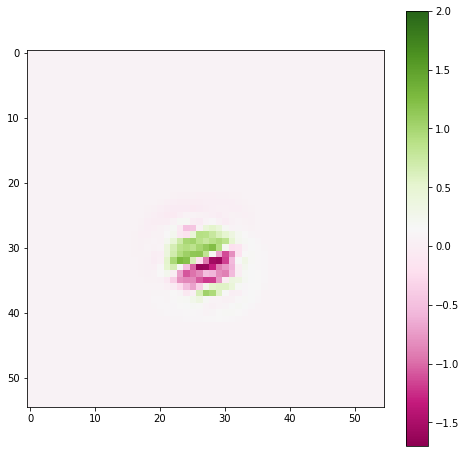

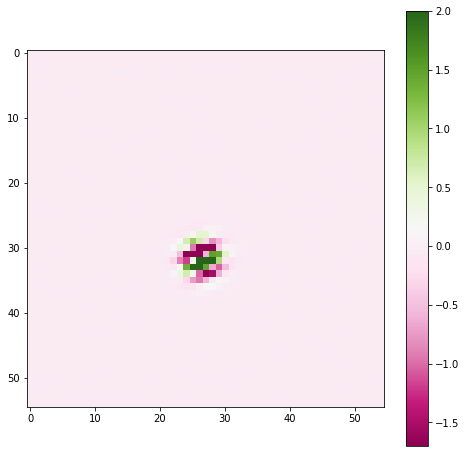

loss = -0.01015186682343483: 100%|██████████| 4000/4000 [00:14<00:00, 284.01it/s] 


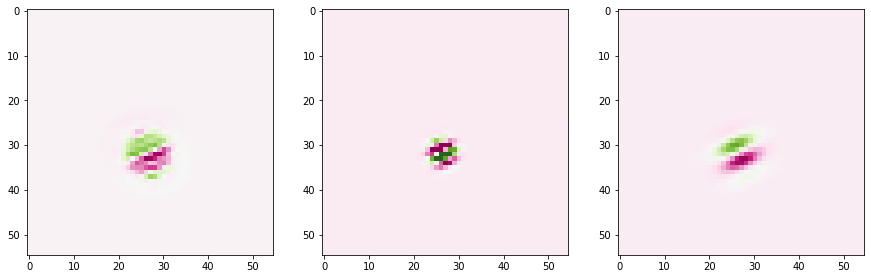

Sigmas_x [0.56400615, 0.5897774]
Sigmas_y [0.67069715, 0.6438116]
fs [0.61634254, 0.5621568]


In [12]:
stds = [0.15]
fs_bm = []
sigmas_x_bm = []
sigmas_y_bm = []
fs_em = []
sigmas_x_em = []
sigmas_y_em = []


device = "cuda" if torch.cuda.is_available() else "cpu"

num_neurons_to_test = 2

# try different neurons
for neuron in range(num_neurons_to_test):
    meis_bm = []
    meis_em = []

    # and different stds
    for std in stds:
        # first, find the MEI

        mei = train_mei(bottleneck_model, device, neuron, std=std)
        meis_bm.append(mei)
        mei = train_mei(energy_model, device, neuron, std=std)
        meis_em.append(mei)

        plot_img(meis_bm[-1], -1.7, 2)
        plot_img(meis_em[-1], -1.7, 2)

    for i in range(len(stds)):
        # now, find the gabor
        std = stds[i]
        g = GaborFilter(
            init_pos_x=pos_x[neuron],
            init_pos_y=pos_y[neuron],
            init_ori=orientations[neuron],
            init_f=1.2,
            dataset_default_ori_shift=90
        )
        
        gab = train_gabor(g, meis_bm[-1], device)

        # bottleneck_model, energy_model, gabor trained on bottleneck_model

        # show_three_images(mei.cpu().detach().numpy(), gab.cpu().detach().numpy(), mei.cpu().detach().numpy() - gab.cpu().detach().numpy(), -1.7, 2)
        for name, param in g.named_parameters():
            if name == "sigma_x":
                sigmas_x_bm.append(param.cpu().detach().numpy()[0])
            if name == "sigma_y":
                sigmas_y_bm.append(param.cpu().detach().numpy()[0])
            if name == "f":
                fs_bm.append(param.cpu().detach().numpy()[0])
        

        show_three_images(meis_bm[-1], meis_em[-1], gab, -1.7, 2)
        
        print("Sigmas_x", sigmas_x_bm)
        print("Sigmas_y", sigmas_y_bm)
        print("fs", fs_bm)
